In [ ]:
#UNIFORM DISTR. --> 2 NEURONS
#                       

import torch
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader
import random
from mpl_toolkits.axes_grid1 import AxesGrid

In [62]:
#Architecture parameters and distributions of stimuli
N = 2
K = 10
p_x = torch.distributions.uniform.Uniform(0,15)

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500
#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]  #creates a 1D tensor of size 1000 whose values are evenly spaced from x_min and x_max



In [63]:
#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted)
dec_perc = MLPDecoder(N,200)


Text(0, 0.5, 'Encoding')

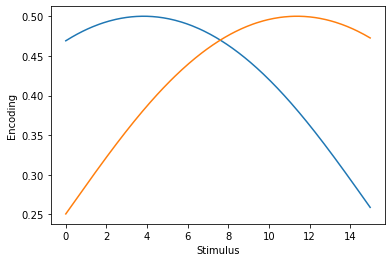

In [64]:
#Initialized encoder before training
plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [65]:
#create the matrix of the total possible vectors of r (possible patterns) for N=10 neurons
r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
r1.shape
r = torch.tensor(r1).transpose(0,1)
r.shape
r


tensor([[0, 0, 1, 1],
        [0, 1, 0, 1]], dtype=torch.int32)

GRADIENT DESCENT ON THE WHOLE SET OF PARAMETERS ( encoder, decoder, h, J)    

In [66]:
def rate_ising_learn(x,encoder,h,J):
    eta = encoder(x)
    r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
    r = torch.tensor(r1).transpose(0,1).type(torch.float)
    p_r_x = torch.exp(eta@r - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
    log_ratio = ((eta-h0)@r - (r*(J0@r)).sum(dim=0, keepdim=True) - (torch.log(1+torch.exp(eta))).sum(dim=1)[:,None])
    logz = torch.log((torch.exp((h0@r) + (r*(J0@r)).sum(dim=0, keepdim=True))).sum(dim=1))

    return ((p_r_x)*(log_ratio)).sum(dim=1).mean() + logz

#Definition of the rate function for the Ising prior

class rate_ISING(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        h0 = torch.zeros((1,N)).type(torch.float)
        J0 = torch.eye(N).type(torch.float)
        self.h = torch.nn.Parameter(h0)
        self.J = torch.nn.Parameter(J0)
    def forward(self,x):
        eta = enc(x) 
        r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
        r = torch.tensor(r1).transpose(0,1).type(torch.float)
        p_r_x = torch.exp(eta@r - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
        log_ratio = ((eta-self.h)@r - (r*(self.J@r)).sum(dim=0, keepdim=True) - (torch.log(1+torch.exp(eta))).sum(dim=1)[:,None])
        logz = torch.log((torch.exp((self.h@r) + (r*(self.J@r)).sum(dim=0, keepdim=True))).sum(dim=1))
        
        return ((p_r_x)*(log_ratio)).sum(dim=1).mean() + logz

In [67]:
#Training
lossVec = []
rateVec = []
distVec = []
rate_i = rate_ISING()
params = list(enc.parameters()) + list(dec_perc.parameters()) + list(rate_i.parameters())
optimizer = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        rate = rate_i(x_)
        dist = distortion_gaussian(x_,enc,dec_perc)
        loss = rate + dist
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

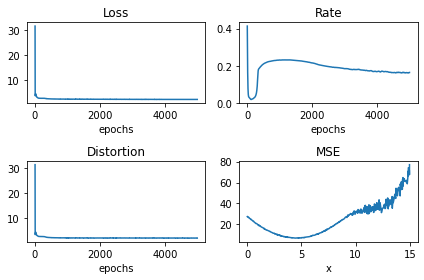

In [68]:
r = enc.sample(x_sorted,100)
x_dec = dec_perc.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()


Text(0, 0.5, 'Encoding')

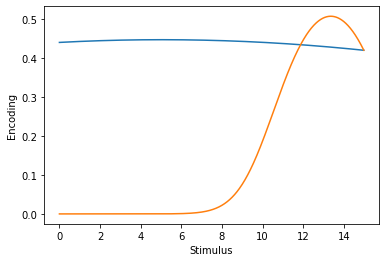

In [69]:
#Tuning curves with learned parameters
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

I want to find the best parameters h and J that minimize the rate considering a fixed encoder whose parameters are kept equal to the initialized ones (first step of EM). 
The parameters being optimized are then the decoder's ones + h and J

In [70]:
lossVec = []
rateVec = []
distVec = []
rate_i = rate_ISING()
J0 = torch.eye(N).type(torch.float)
h0 = torch.zeros((1,N)).type(torch.float)
params = list(dec_perc.parameters()) + list(rate_i.parameters())
optimizer = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        rate = rate_i(x_)
        dist = distortion_gaussian(x_,enc,dec_perc)
        loss = rate + dist
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

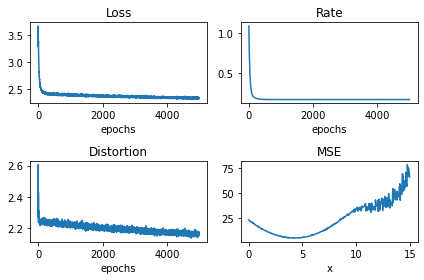

In [71]:
r = enc.sample(x_sorted,100)
x_dec = dec_perc.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()

In [72]:
rate_i.h
rate_i.J

Parameter containing:
tensor([[ 0.3831, -0.0215],
        [-0.0215, -0.3480]], requires_grad=True)

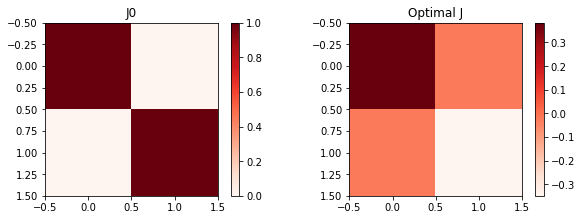

In [73]:
a = (rate_i.J).detach() 
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
cmap = cm.Reds

fig.add_subplot(rows, columns, 1)
plt.imshow(J0, cmap)
plt.title("J0")
plt.colorbar()


fig.add_subplot(rows, columns, 2)
plt.imshow(a, cmap)
plt.title("Optimal J")
plt.colorbar()

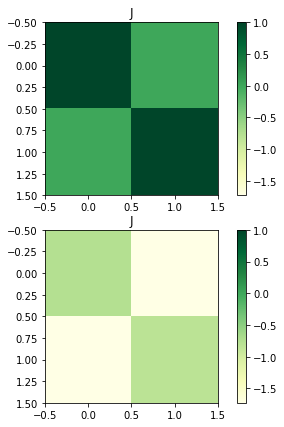

In [85]:
J0 = torch.eye(N).type(torch.float)
a = (rate_i.J).detach() 
def show_plots(elements):
    
    combined_data = torch.stack(elements).detach().numpy()
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure(figsize=(7,7))
    for i in range(len(elements)):
        ax = fig.add_subplot(len(elements), 1, i+1)
        #Add the vmin and vmax arguments to set the color scale
        im=ax.imshow(elements[i],cmap=plt.cm.YlGn, vmin = _min, vmax = _max)
        ax.set_title("J")
        fig.colorbar(im, ax=ax)
        #ax.autoscale(True)

    plt.show()

show_plots([J0, a])

Given the optimal h and J, I want to see how the rate changes when varying the sigmas of the encoding process tuning curves.


In [75]:
opt_h = rate_i.h
opt_J = rate_i.J

In [104]:
def initialize_bernoulli_params_sigma(N,x_min,x_max,xs,w):
    # w = new parameter used in the definition of the curve's width 
    #cs are initialized using kmeans:
    kmeans = cluster.KMeans(n_clusters=N, init='random', n_init=10, max_iter=10, random_state=2)
    C = kmeans.fit_predict(xs)
    centers = kmeans.cluster_centers_
    cs = torch.nn.Parameter(torch.Tensor(centers).transpose(0,1))
    log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*(x_max-x_min)/w)[None,:])
    As = torch.nn.Parameter(torch.ones(N)[None,:])
    return cs,log_sigmas,As

def rate_ising3(x,encoder,h,J):
    eta = encoder(x)
    r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
    r = torch.tensor(r1).transpose(0,1).type(torch.float)
    p_r_x = torch.exp(eta@r - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
    log_ratio = ((eta-h0)@r - (r*(J0@r)).sum(dim=0, keepdim=True) - (torch.log(1+torch.exp(eta))).sum(dim=1)[:,None])
    logz = torch.log((torch.exp((h0@r) + (r*(J0@r)).sum(dim=0, keepdim=True))).sum(dim=1))

    return ((p_r_x)*(log_ratio)).sum(dim=1).mean() + logz

def initialize_bernoulli_params_mu(N,x_min,x_max,xs,w):
    # w = new parameter used in the definition of the curve's centroid
    cs = torch.nn.Parameter(torch.arange(x_min,x_max,(x_max-x_min)/w)[None,0:N])
    log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*(x_max-x_min)/N)[None,:])
    As = torch.nn.Parameter(torch.ones(N)[None,:])
    return cs,log_sigmas,As

class BernoulliEncoder(torch.nn.Module):
    # Encoder returning for N neurons their unnormalized probabilities of being active (i.e. logits),as 
    # a quadratic function of x
    def __init__(self,N,x_min,x_max,xs,w):
        super().__init__()
        self.cs, self.log_sigmas,self.As  = initialize_bernoulli_params_sigma(N,x_min,x_max,xs,w)
    def forward(self,x):
        # x has shape [bsize_dim,x_dim], c,log_sigma,A has shape [x_dim, N]
        inv_sigmas = 0.5*torch.exp(-2*self.log_sigmas)
        etas = -(x**2)@inv_sigmas
        etas2 = + 2*x@((self.cs*inv_sigmas))
        etas3 = - (self.cs**2)*inv_sigmas + torch.log(self.As)
        return etas + etas2 + etas3

    def sample(self,x,nsamples):
        p_r_x = torch.distributions.bernoulli.Bernoulli(logits = self.forward(x))
        r = p_r_x.sample((nsamples,)).transpose(0,1)
        return r



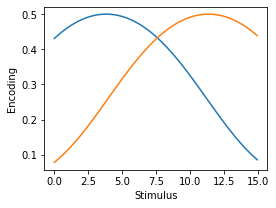

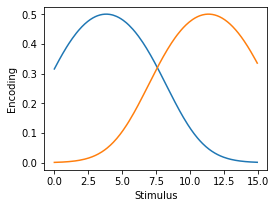

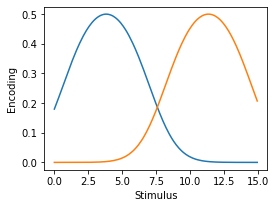

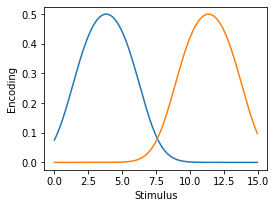

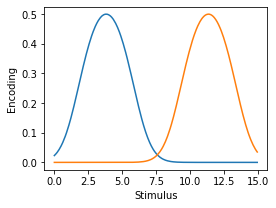

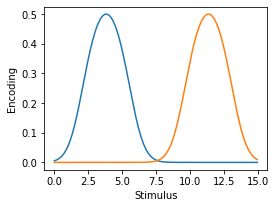

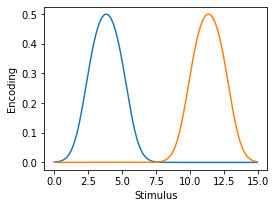

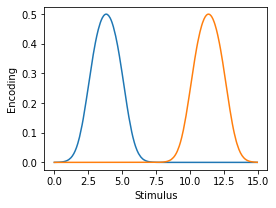

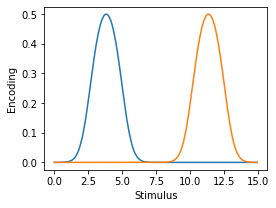

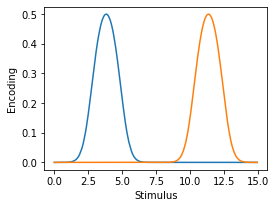

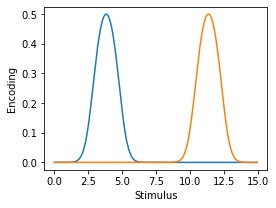

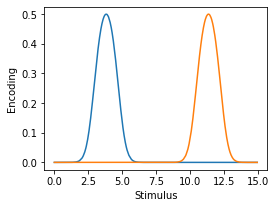

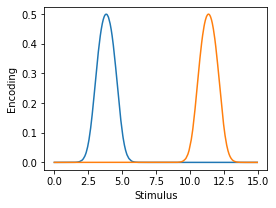

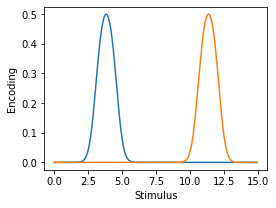

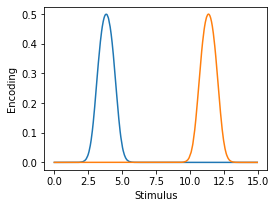

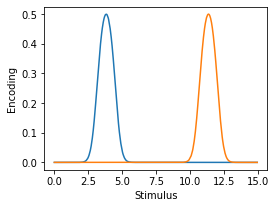

In [96]:
#Visualizing how the tuning curves vary when I vary w
for w in range(3,35,2):
    

    fig = plt.figure(figsize=(4, 3))
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    fig.add_subplot()
    plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding")

In [78]:
rateVec = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    rate = rate_ising3(x_sorted, enc, opt_h, opt_J)
    rateVec.append(rate.item())

sigmas = []
for w in range(3,30,2):
    sigma = (x_max-x_min)/w
    sigmas.append(sigma)


Text(0.5, 1.0, 'Rate as a function of sigma')

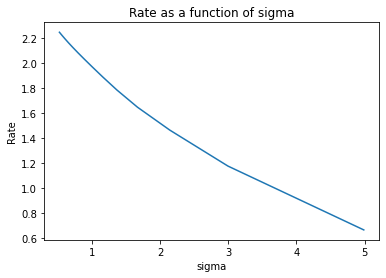

In [79]:
plt.plot(sigmas,rateVec)
plt.xlabel("sigma")
plt.ylabel("Rate")
plt.title("Rate as a function of sigma")

In [80]:
J0 = torch.eye(N).type(torch.float)
h0 = torch.zeros((1,N)).type(torch.float)
rateVec = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    rate_i = rate_ISING()
    params = list(dec_perc.parameters()) + list(rate_i.parameters())
    optimizer = torch.optim.Adam(params,lr)
    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           rate = rate_i(x_)
           dist = distortion_gaussian(x_,enc,dec_perc)
           loss = rate + dist
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
    rateVec.append(rate.item())


Text(0.5, 1.0, 'Rate as a function of sigma')

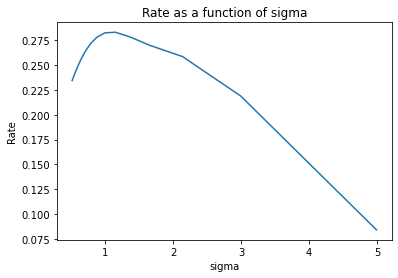

In [81]:
plt.plot(sigmas, rateVec)
plt.xlabel("sigma")
plt.ylabel("Rate")
plt.title("Rate as a function of sigma")

I want to check how J varies when the sigmas are varied. The encoder is fixed, I'm performing gradient descent only on h,J and the decoder parameters

In [82]:
J0 = torch.eye(N).type(torch.float)
h0 = torch.zeros((1,N)).type(torch.float)
Js = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    rate_i = rate_ISING()
    params = list(dec_perc.parameters()) + list(rate_i.parameters())
    optimizer = torch.optim.Adam(params,lr)
    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           rate = rate_i(x_)
           dist = distortion_gaussian(x_,enc,dec_perc)
           loss = rate + dist
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
       
    J_item = rate_i.J.detach()
    Js.append(J_item)

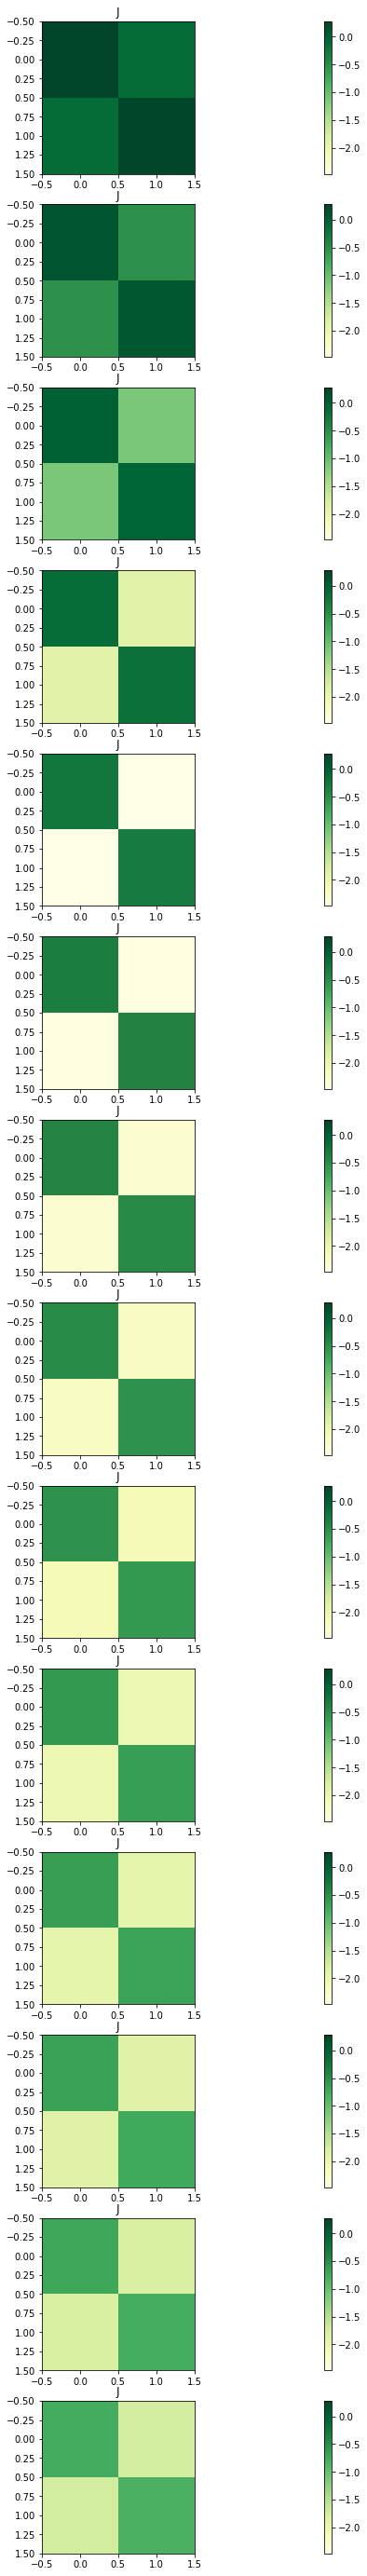

In [88]:
from mpl_toolkits.axes_grid1 import AxesGrid
def show_plots(elements):
    
    combined_data = torch.stack(elements).detach().numpy()
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure(figsize=(50,50))
    for i in range(len(elements)):
        ax = fig.add_subplot(len(elements), 1, i+1)
        #Add the vmin and vmax arguments to set the color scale
        im=ax.imshow(elements[i],cmap=plt.cm.YlGn, vmin = _min, vmax = _max)
        ax.set_title("J")
        fig.colorbar(im, ax=ax)
        

    plt.show()
show_plots(Js)

I repeat the same analysis I've just performed varying the curves' widths and analyzing the correspective J matrices, but this time varying their centroids.

In [155]:
def initialize_bernoulli_params_mu(N,x_min,x_max,xs,w):
    # w = new parameter used in the definition of the curve's centroid
    cs = torch.nn.Parameter(torch.arange(x_min,x_max,(x_max-w-x_min)/N)[None,0:N])
    log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*(x_max-x_min)/N)[None,0:N])
    As = torch.nn.Parameter(torch.ones(N)[None,:])
    return cs,log_sigmas,As


class BernoulliEncoder(torch.nn.Module):
    # Encoder returning for N neurons their unnormalized probabilities of being active (i.e. logits),as 
    # a quadratic function of x
    def __init__(self,N,x_min,x_max,xs,w):
        super().__init__()
        self.cs, self.log_sigmas,self.As  = initialize_bernoulli_params_mu(N,x_min,x_max,xs,w)
    def forward(self,x):
        # x has shape [bsize_dim,x_dim], c,log_sigma,A has shape [x_dim, N]
        inv_sigmas = 0.5*torch.exp(-2*self.log_sigmas)
        etas = -(x**2)@inv_sigmas
        etas2 = + 2*x@((self.cs*inv_sigmas))
        etas3 = - (self.cs**2)*inv_sigmas + torch.log(self.As)
        return etas + etas2 + etas3

    def sample(self,x,nsamples):
        p_r_x = torch.distributions.bernoulli.Bernoulli(logits = self.forward(x))
        r = p_r_x.sample((nsamples,)).transpose(0,1)
        return r

Parameter containing:
tensor([[-0.1957,  7.4881]], requires_grad=True)
Parameter containing:
tensor([[-0.1957,  6.9881]], requires_grad=True)
Parameter containing:
tensor([[-0.1957,  6.4881]], requires_grad=True)
Parameter containing:
tensor([[-0.1957,  5.9881]], requires_grad=True)
Parameter containing:
tensor([[-0.1957,  5.4881]], requires_grad=True)
Parameter containing:
tensor([[-0.1957,  4.9881]], requires_grad=True)
Parameter containing:
tensor([[-0.1957,  4.4881]], requires_grad=True)
Parameter containing:
tensor([[-0.1957,  3.9881]], requires_grad=True)
Parameter containing:
tensor([[-0.1957,  3.4881]], requires_grad=True)
Parameter containing:
tensor([[-0.1957,  2.9881]], requires_grad=True)


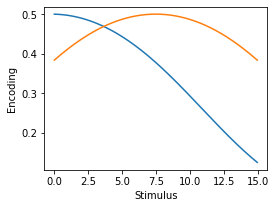

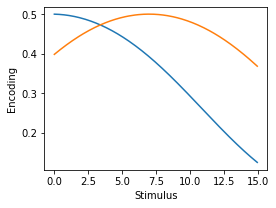

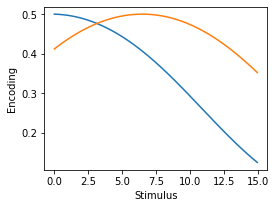

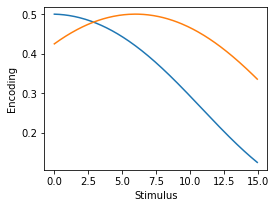

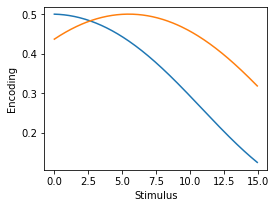

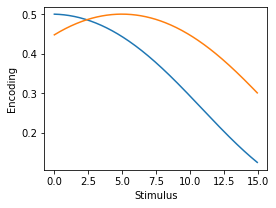

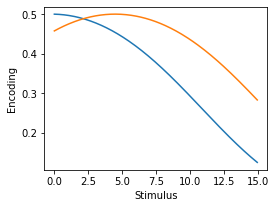

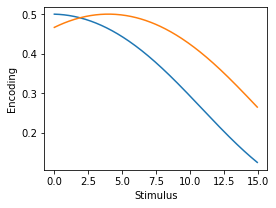

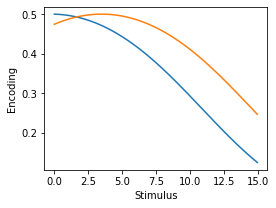

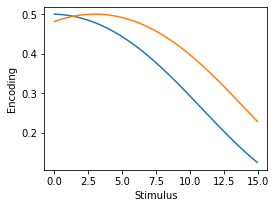

In [156]:
#Visualizing how the tuning curves vary when I vary w
for w in range(0,10,1):
    fig = plt.figure(figsize=(4, 3))
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    fig.add_subplot()
    plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding")
    print(enc.cs)

In [159]:
J0 = torch.eye(N).type(torch.float)
h0 = torch.zeros((1,N)).type(torch.float)
Js = []
for w in range(0,10,1):
    enc = BernoulliEncoder(N,x_min,x_max,x_sorted,w)
    rate_i = rate_ISING()
    params = list(dec_perc.parameters()) + list(rate_i.parameters())
    optimizer = torch.optim.Adam(params,lr)
    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           rate = rate_i(x_)
           dist = distortion_gaussian(x_,enc,dec_perc)
           loss = rate + dist
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
       
    J_item = rate_i.J.detach()
    Js.append(J_item)

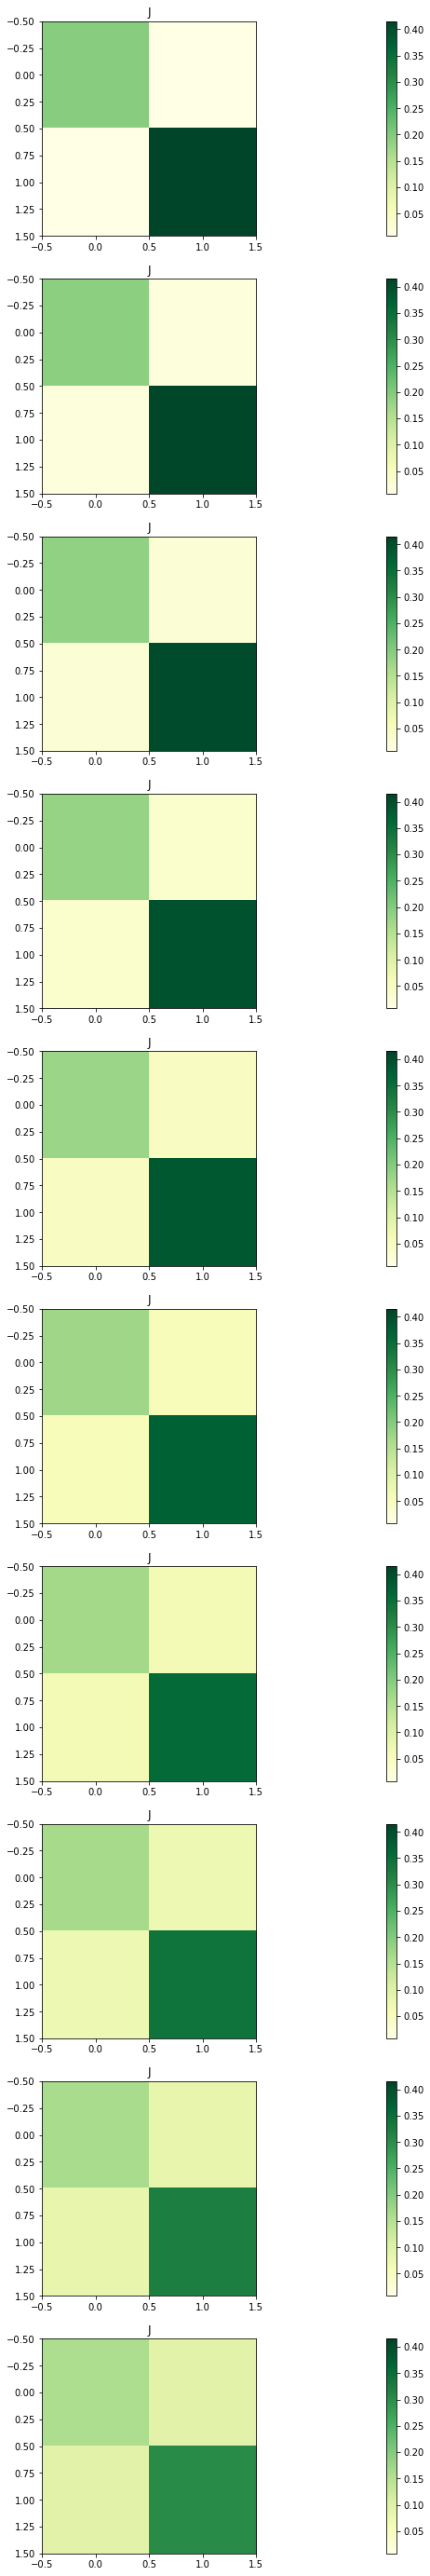

In [160]:
show_plots(Js)